In [18]:
import torch
import alpha_clip
from PIL import Image
import numpy as np
import random
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

%matplotlib inline


In [19]:
from image_utils import mask_image, crop_object_from_white_background

In [20]:
# load model and prepare mask transform
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cuda


In [21]:
model, preprocess = alpha_clip.load("ViT-L/14", alpha_vision_ckpt_pth="../checkpoints/clip_l14_grit20m_fultune_2xe.pth", device=device)  # change to your own ckpt path


In [22]:
mask_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Resize((224, 224)), # change to (336,336) when using ViT-L/14@336px
    transforms.Normalize(0.5, 0.26)
])


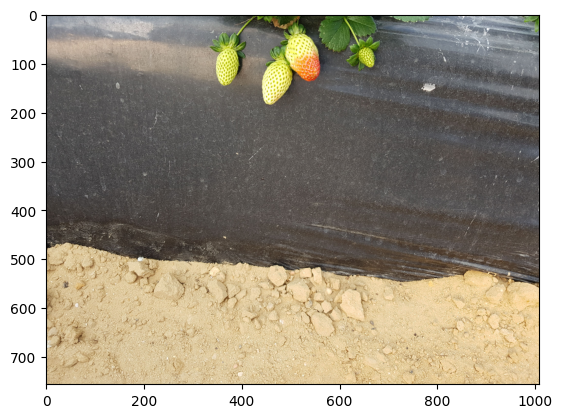

In [23]:
image_segs_folder = "../examples/strawberry/1"
rgb_image = cv2.cvtColor(cv2.imread(image_segs_folder + "/1.png"), cv2.COLOR_BGR2RGB)
plt.imshow(rgb_image)

In [24]:
def get_masked_image(image_segs_folder, mask_id):
    mask_img_path = image_segs_folder + "/mask_%i.png"%mask_id
    mask_img = cv2.imread(mask_img_path)[:, :, 0] # only one layer mask is needed
    print("mask_img_path: ", mask_img_path)
    masked_image = mask_image(rgb_image, mask_img)
    return masked_image

mask_img_path:  ../examples/strawberry/1/mask_10.png
mask_img_path:  ../examples/strawberry/1/mask_23.png
mask_img_path:  ../examples/strawberry/1/mask_60.png
mask_img_path:  ../examples/strawberry/1/mask_35.png
mask_img_path:  ../examples/strawberry/1/mask_47.png
mask_img_path:  ../examples/strawberry/1/mask_34.png
mask_img_path:  ../examples/strawberry/1/mask_29.png
mask_img_path:  ../examples/strawberry/1/mask_43.png


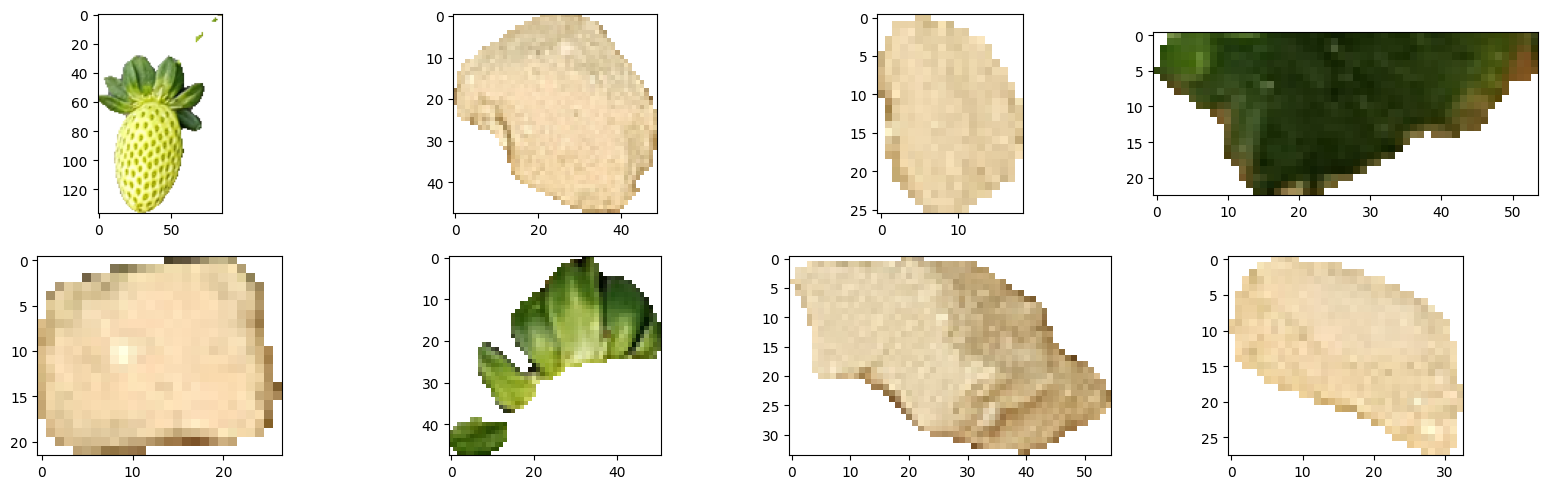

In [25]:

original_images = []
images = []
plt.figure(figsize=(16, 5))
mask_ids = [random.randint(0, 100) for _ in range(8)]
for i, mask_id in enumerate(mask_ids):
    masked_image = get_masked_image(image_segs_folder, mask_id)
    image = crop_object_from_white_background(masked_image)

    plt.subplot(2, 4, i+1)
    plt.imshow(image)
    original_images.append(image)
    images.append(preprocess(image))

plt.tight_layout()


In [26]:
def alpha_clip_prediction(image, mask, texts):
    # tokenize text
    text_tokens = alpha_clip.tokenize([desc for desc in texts]).to(device)

    # preprocess image and mask
    image = preprocess(image.copy()).unsqueeze(0).half().to(device)
    # get `binary_mask` array (2-dimensional bool matrix)
    if len(mask.shape) == 2: binary_mask = (mask == 255)
    if len(mask.shape) == 3: binary_mask = (mask[:, :, 0] == 255)
    alpha = mask_transform((binary_mask * 255).astype(np.uint8))
    alpha = alpha.half().cuda().unsqueeze(dim=0)

    # calculate image and text features
    with torch.no_grad():
        image_features = model.visual(image, alpha)
        text_features = model.encode_text(text_tokens)

    # normalize
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    ## calc the similarity
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1).cpu().numpy()
    label = texts[np.argmax(similarity)]
    return label, similarity

def plot_similarity_bar(texts, similarity):
    similarity_plt = similarity.reshape(1, -1)  # Reshape if necessary
    # Create the bar chart
    plt.figure(figsize=(10, 6))  # Adjust figure size as desired
    plt.bar(texts, similarity_plt[0], color='skyblue')  # Use first row of similarity
    plt.ylabel("Similarity Score")
    plt.title("Similarity Scores for Text Descriptions")
    # Rotate x-axis labels for better readability with long texts
    plt.xticks(rotation=45, ha='right')  # Rotate and right-align x-axis labels
    # Display the plot
    plt.tight_layout()
    plt.show()

def plot_masked_image(image, mask):
    """Plots an image with the masked area highlighted using transparency.

    Args:
        image: The input image as a NumPy array.
        mask: The binary mask as a NumPy array (single-channel, data type `uint8`).
    """
    alpha = mask[:, :, :]/255
    masked_image = alpha * np.asarray(image)/255
    plt.imshow(0.7 * masked_image + 0.3*np.asarray(image)/255)
    plt.axis('off')  # Hide axes for cleaner visualization
    plt.show()


### Prediction example full image

In [36]:
texts = [
"a red strawberry",
"a green strawberry",
"a green leaf or leaves with jagged edges",
"a green long and thin stem",
"a white flower",
"a yellow stone or black plastic or soil or something else"]
print(texts)

['a strawberry', 'a green leaves, leaf', 'a green stem', 'a white flower', 'a stone or black plastic or soil or something else']


In [37]:
# Load image and mask
full_image_path = image_segs_folder + "/1.png"
mask_id = 96
mask_path = image_segs_folder + "/mask_%i.png"%mask_id
image = Image.open(full_image_path).convert('RGB')
mask = np.array(Image.open(mask_path)) 


a strawberry


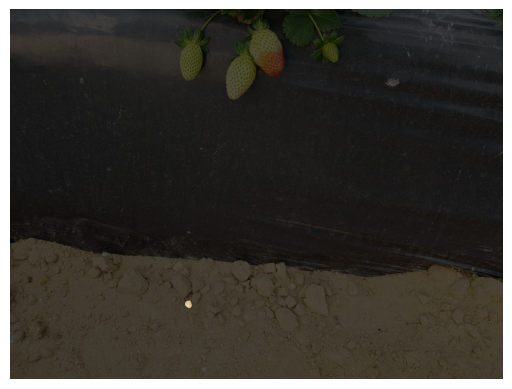

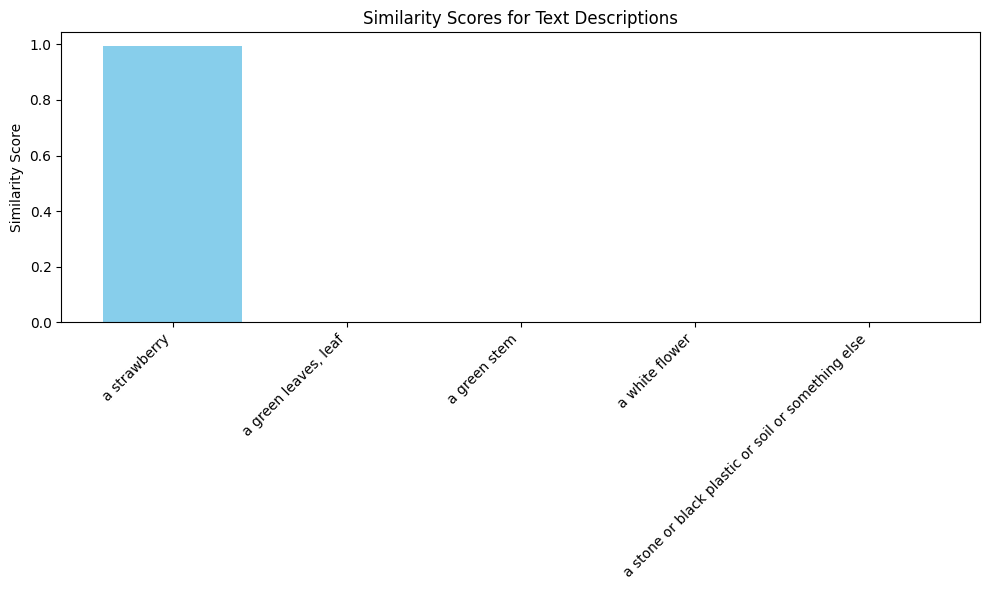

In [39]:
label, similarity = alpha_clip_prediction(image, mask, texts)
print(label)
plot_masked_image(image, mask)
plot_similarity_bar(texts, similarity)

### Prediction example croped image

In [40]:
# Load image and mask
full_image_path = image_segs_folder + "/1.png"
mask_id = 96
mask_path = image_segs_folder + "/mask_%i.png"%mask_id
image = Image.open(full_image_path).convert('RGB')
mask = np.array(Image.open(mask_path)) 


In [41]:
def crop_object_from_mask(image, mask):
    """Crops an image with a mask to the minimal bounding box containing a non-white object.
    """
    # Load the image
    # Find valid pixels
    valid_mask = np.any(mask != 0, axis=2)  # Check all color channels
    # Find bounding box coordinates
    ymin, xmin = np.where(valid_mask)[0].min(), np.where(valid_mask)[1].min()
    ymax, xmax = np.where(valid_mask)[0].max() + 1, np.where(valid_mask)[1].max() + 1
    # Crop the image
    cropped_mask = Image.fromarray(mask)
    cropped_img = image.crop((xmin, ymin, xmax, ymax))
    cropped_mask = cropped_mask.crop((xmin, ymin, xmax, ymax))
    cropped_mask = np.asarray(cropped_mask)
    return cropped_img, cropped_mask

In [42]:
cropped_img, cropped_mask = crop_object_from_mask(image, mask)

a white flower


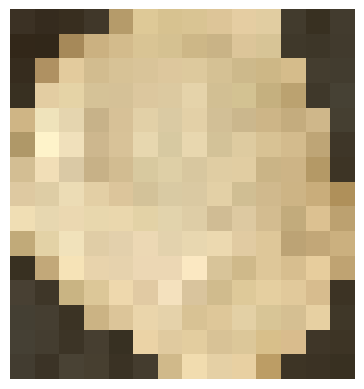

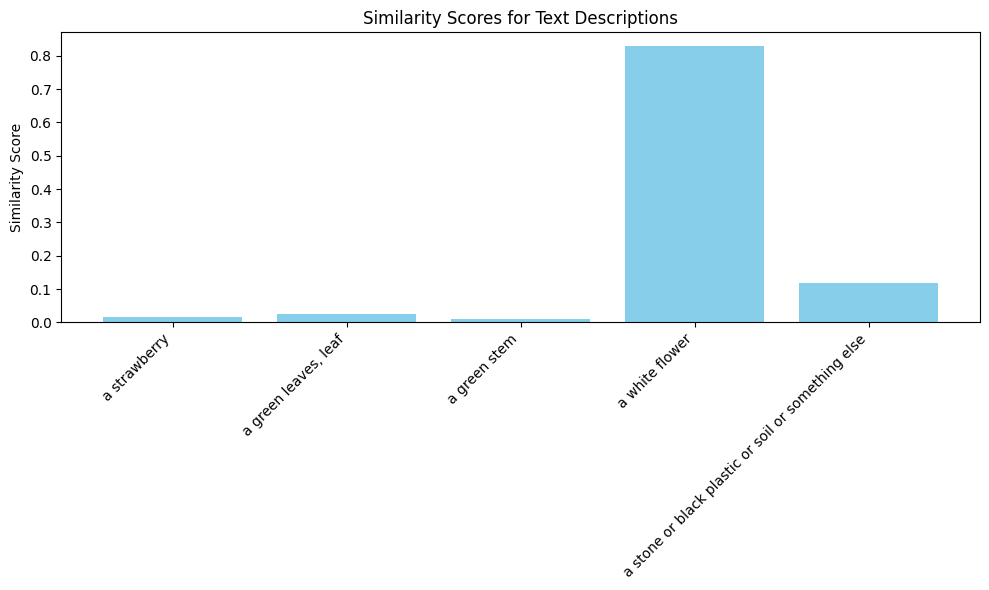

In [43]:
label, similarity = alpha_clip_prediction(cropped_img, cropped_mask, texts)
print(label)
plot_masked_image(cropped_img, cropped_mask)
plot_similarity_bar(texts, similarity)